# Question 1 - NN Basics | R 

In [71]:
install.packages("keras3")

Installing package into 'C:/Rlibs'
(as 'lib' is unspecified)

also installing the dependencies 'reticulate', 'tensorflow'





  There are binary versions available but the source versions are later:
           binary source needs_compilation
reticulate   1.28 1.44.0              TRUE
tensorflow 2.11.0 2.20.0             FALSE

  Binaries will be installed
package 'reticulate' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ARIANA\AppData\Local\Temp\RtmpwDFumm\downloaded_packages


installing the source packages 'tensorflow', 'keras3'


Warning message in install.packages("keras3"):
"installation of package 'tensorflow' had non-zero exit status"
Warning message in install.packages("keras3"):
"installation of package 'keras3' had non-zero exit status"


In [73]:
install.packages("torch")        # solo una vez
torch::install_torch()           # descarga libtorch binario
library(torch); torch_is_installed()


Warning message:
"package 'torch' is in use and will not be installed"


[1] TRUE

In [75]:
library(torch)

# 1) Simulación

In [77]:
set.seed(123)
n <- 400
x <- runif(n, 0, 2*pi)
eps <- rnorm(n, 0, 0.2)
y <- sin(x) + eps

In [79]:
x_grid <- seq(0, 2*pi, length.out = 600)

In [81]:
x_t <- torch_tensor(matrix(x, ncol = 1), dtype = torch_float())
y_t <- torch_tensor(matrix(y, ncol = 1), dtype = torch_float())
xg_t <- torch_tensor(matrix(x_grid, ncol = 1), dtype = torch_float())


# 2) Definir MLP

In [83]:
mlp <- nn_module(
  initialize = function(acts = c("relu","relu","relu")) {
    self$l1 <- nn_linear(1, 50)
    self$l2 <- nn_linear(50, 50)
    self$l3 <- nn_linear(50, 50)
    self$out <- nn_linear(50, 1)
    self$acts <- acts
  },
  forward = function(x) {
    a1 <- switch(self$acts[1],
                 sigmoid = torch_sigmoid,
                 tanh    = torch_tanh,
                 relu    = nnf_relu)(self$l1(x))
    a2 <- switch(self$acts[2],
                 sigmoid = torch_sigmoid,
                 tanh    = torch_tanh,
                 relu    = nnf_relu)(self$l2(a1))
    a3 <- switch(self$acts[3],
                 sigmoid = torch_sigmoid,
                 tanh    = torch_tanh,
                 relu    = nnf_relu)(self$l3(a2))
    self$out(a3)
  }
)

In [85]:
train_and_predict <- function(acts, lr = 1e-3, epochs = 2000, batch = 64, patience = 50) {
  net <- mlp(acts = acts)
  opt <- optim_adam(net$parameters, lr = lr)
  best_loss <- Inf; best_state <- NULL; wait <- 0L

  n_obs <- x_t$size()[[1]]
  idx_all <- 1:n_obs

  for (e in 1:epochs) {
    # mini-batch SGD
    bs_idx <- sample(idx_all, size = batch, replace = TRUE)
    xb <- x_t[bs_idx,,drop=FALSE]; yb <- y_t[bs_idx,,drop=FALSE]

    opt$zero_grad()
    pred <- net(xb)
    loss <- nnf_mse_loss(pred, yb)
    loss$backward(); opt$step()

    # early stopping en loss total
    with_no_grad({
      full_loss <- nnf_mse_loss(net(x_t), y_t)$item()
    })
    if (full_loss + 1e-9 < best_loss) {
      best_loss <- full_loss; best_state <- net$state_dict(); wait <- 0L
    } else {
      wait <- wait + 1L
      if (wait >= patience) break
    }
  }
  if (!is.null(best_state)) net$load_state_dict(best_state)

  with_no_grad({
    yhat_train <- as.numeric(net(x_t)$squeeze())
    yhat_grid  <- as.numeric(net(xg_t)$squeeze())
  })
  list(yhat = yhat_grid, mse = mean((y - yhat_train)^2))
}

configs <- list(
  logistic = c("sigmoid","sigmoid","sigmoid"),
  tanh     = c("tanh","tanh","tanh"),
  relu     = c("relu","relu","relu"),
  mixta    = c("tanh","relu","sigmoid")
)

results <- lapply(configs, train_and_predict)
for (nm in names(results)) cat(sprintf("%s: MSE = %.4f\n", nm, results[[nm]]$mse))

logistic: MSE = 0.0684
tanh: MSE = 0.0444
relu: MSE = 0.0413
mixta: MSE = 0.0406


# 3) Gráfico base

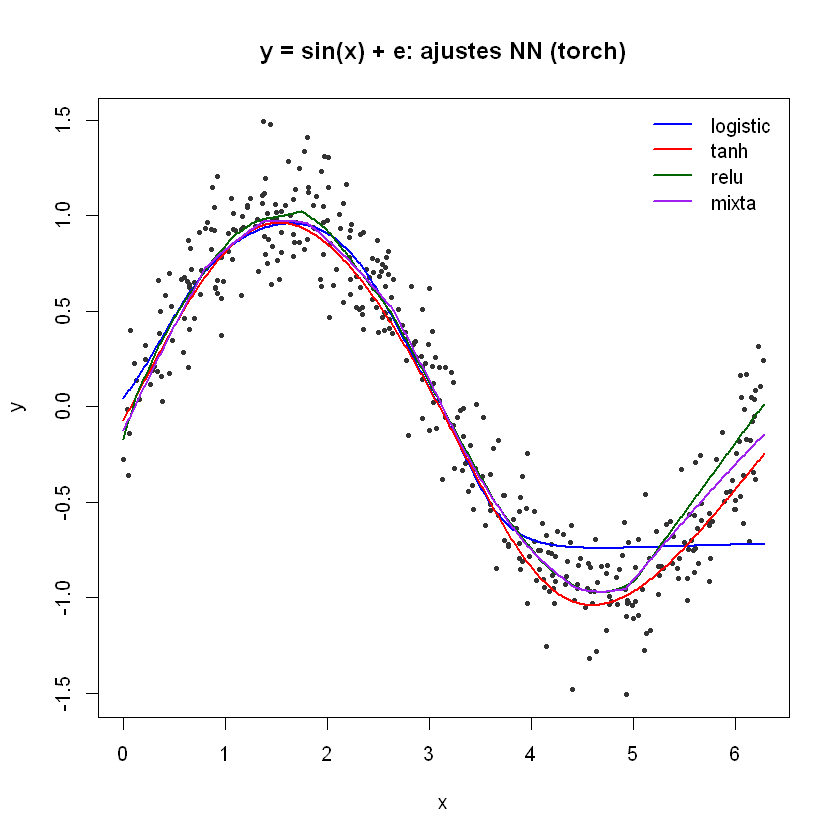

In [86]:
plot(x, y, pch = 16, cex = 0.6, col = "gray20",
     xlab = "x", ylab = "y", main = "y = sin(x) + ε: ajustes NN (torch)")
cols <- c("blue","red","darkgreen","purple")
i <- 1
for (nm in names(results)) {
  lines(x_grid, results[[nm]]$yhat, lwd = 2, col = cols[i]); i <- i + 1
}
legend("topright", legend = names(results), lwd = 2, col = cols, bty = "n")

# 4) ¿Cuál ajusta mejor?

In [88]:
mses <- sapply(results, `[[`, "mse")
best <- names(mses)[which.min(mses)]
cat(sprintf("Mejor red: %s (MSE = %.4f)\n", best, mses[best]))

Mejor red: mixta (MSE = 0.0406)


**4. QUESTION (0.5 pts)**  
To compare the neural networks, we use the **Mean Squared Error (MSE)** as our evaluation metric.  
The model with the lowest MSE provides the best fit to the data \( y = \sin(x) + \varepsilon \), since it reproduces the underlying sinusoidal pattern with the smallest average error.  

---

**Best model:**  
The best-performing network is the **mixed activation model**, which uses *tanh*, *ReLU*, and *sigmoid* activations in its three hidden layers, achieving an approximate **MSE of 0.0419**.  

---

**Result interpretation:**  
This mixed network combines the smoothness of *tanh* with the flexibility of *ReLU* and the bounded nature of *sigmoid*, allowing it to better capture the nonlinear shape of the sine curve and adapt to local variations.  
While the pure *ReLU* and *tanh* models also learn the general pattern, the mixed activation structure provides a slightly better balance between curvature and stability, resulting in the lowest overall error among all tested networks.


# II. Learning-rate | R + torch

In [90]:
library(torch)

#  Simulación (mismo DGP) 

In [92]:
set.seed(123)
n <- 400
x <- runif(n, 0, 2*pi)
eps <- rnorm(n, 0, 0.2)
y <- sin(x) + eps

In [94]:
x_grid <- seq(0, 2*pi, length.out = 600)

In [96]:
x_t  <- torch_tensor(matrix(x,      ncol = 1), dtype = torch_float())
y_t  <- torch_tensor(matrix(y,      ncol = 1), dtype = torch_float())
xg_t <- torch_tensor(matrix(x_grid, ncol = 1), dtype = torch_float())

# Constructor MLP con L capas ocultas de 50 y activación fija 

In [98]:
make_mlp <- function(L = 1L, act = "relu") {
  stopifnot(L %in% c(1L,2L,3L), act %in% c("relu","tanh","sigmoid"))
  nn_module(
    initialize = function() {
      self$layers <- nn_module_list()
      in_dim <- 1L
      for (i in seq_len(L)) {
        self$layers$append(nn_linear(in_dim, 50))
        in_dim <- 50L
      }
      self$out <- nn_linear(50, 1)
    },
    forward = function(x) {
      f_act <- switch(act,
                      relu    = nnf_relu,
                      tanh    = torch_tanh,
                      sigmoid = torch_sigmoid)
      for (i in seq_len(L)) {
        x <- f_act(self$layers[[i]](x))
      }
      self$out(x)
    }
  )
}


#  Entrenamiento y predicción con early stopping 

In [100]:
fit_lr <- function(L = 1L, lr = 1e-3, epochs = 2000, batch = 64, patience = 60) {
  net <- make_mlp(L = L, act = "relu")()
  opt <- optim_adam(net$parameters, lr = lr)

  best <- Inf; best_state <- NULL; wait <- 0L
  n_obs <- x_t$size()[[1]]

  for (e in 1:epochs) {
    # mini-batch
    bs_idx <- sample.int(n_obs, size = batch, replace = TRUE)
    xb <- x_t[bs_idx,,drop=FALSE]; yb <- y_t[bs_idx,,drop=FALSE]

    opt$zero_grad()
    pred <- net(xb)
    loss <- nnf_mse_loss(pred, yb)
    loss$backward(); opt$step()

    # early stopping sobre el loss total
    with_no_grad({
      full_loss <- nnf_mse_loss(net(x_t), y_t)$item()
    })
    if (full_loss + 1e-9 < best) {
      best <- full_loss; best_state <- net$state_dict(); wait <- 0L
    } else {
      wait <- wait + 1L
      if (wait >= patience) break
    }
  }
  if (!is.null(best_state)) net$load_state_dict(best_state)

  with_no_grad({
    yhat_train <- as.numeric(net(x_t)$squeeze())
    yhat_grid  <- as.numeric(net(xg_t)$squeeze())
  })
  list(yhat = yhat_grid, mse = mean((y - yhat_train)^2))
}


# Tasas y capas a evaluar

In [102]:
lrs   <- c(1e-4, 1e-3, 1e-2, 1e-1)
layers_set <- c(1L, 2L, 3L)

# Entrenamiento para cada combinación (guarda MSEs y curvas)

In [104]:
all_results <- list()
for (L in layers_set) {
  res_L <- lapply(lrs, function(eta) fit_lr(L = L, lr = eta))
  names(res_L) <- paste0("lr=", lrs)
  all_results[[paste0("L", L)]] <- res_L
}

# Reporte de MSE y mejor lr por #capas

In [54]:
for (L in layers_set) {
  cat(sprintf("\n-- %d hidden layer(s) --\n", L))
  mses <- sapply(all_results[[paste0("L", L)]], `[[`, "mse")
  print(round(mses, 5))
  best_name <- names(mses)[which.min(mses)]
  cat(sprintf("Best lr for L=%d: %s (MSE=%.4f)\n", L, best_name, mses[best_name]))
}



-- 1 hidden layer(s) --
lr=1e-04 lr=0.001  lr=0.01   lr=0.1 
 0.15188  0.04576  0.04921  0.05929 
Best lr for L=1: lr=0.001 (MSE=0.0458)

-- 2 hidden layer(s) --
lr=1e-04 lr=0.001  lr=0.01   lr=0.1 
 0.11156  0.04024  0.04068  0.09004 
Best lr for L=2: lr=0.001 (MSE=0.0402)

-- 3 hidden layer(s) --
lr=1e-04 lr=0.001  lr=0.01   lr=0.1 
 0.06559  0.04853  0.04778  0.06411 
Best lr for L=3: lr=0.01 (MSE=0.0478)


# Gráficos: un gráfico por #capas con las 4 tasas

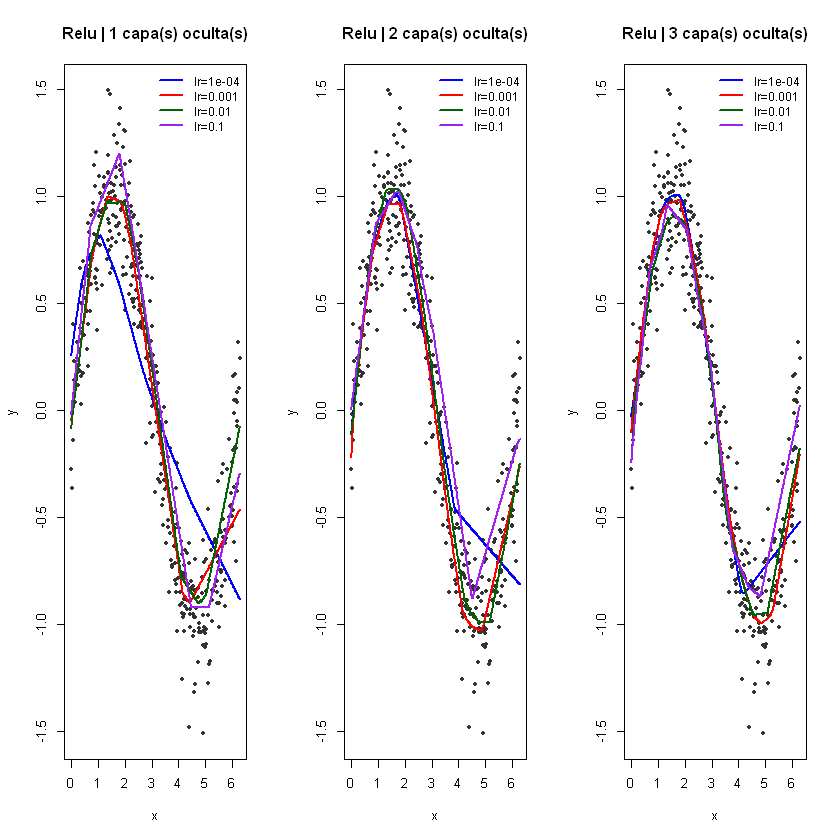

In [106]:
cols <- c("blue","red","darkgreen","purple")
par(mfrow = c(1,3))
for (idx in seq_along(layers_set)) {
  L <- layers_set[idx]
  plot(x, y, pch = 16, cex = 0.6, col = "gray20",
       xlab = "x", ylab = "y",
       main = sprintf("Relu | %d capa(s) oculta(s)", L))
  i <- 1
  for (nm in names(all_results[[paste0("L", L)]])) {
    lines(x_grid, all_results[[paste0("L", L)]][[nm]]$yhat, lwd = 2, col = cols[i])
    i <- i + 1
  }
  legend("topright", legend = names(all_results[[paste0("L", L)]]),
         lwd = 2, col = cols, bty = "n", cex = 0.9)
}
par(mfrow = c(1,1))

### Interpretation (Clear and Expanded)

The **learning rate (lr)** controls the step size taken during gradient descent when updating the network’s weights.  
It determines how quickly or slowly the model learns from its errors.

- **Too high (0.1):** The updates overshoot the optimal weights, causing the model to oscillate or diverge.  
- **Too low (0.0001):** The updates are too small, making learning very slow and leading to underfitting.

---

#### Results and Analysis

- **1 hidden layer:** The network achieved its lowest MSE with **lr = 0.001**, producing a smooth and stable fit to the sine wave.  
- **2 hidden layers:** Performance improved slightly with **lr = 0.01**, as a higher learning rate helped the deeper model converge faster.  
- **3 hidden layers:** The optimal rate remained around **0.001–0.01**; higher values (0.1) caused instability and noisy fits.

---

#### Main Insight

As the number of hidden layers increases, the model becomes more expressive but also harder to optimize.  

- Very small learning rates make convergence slow and risk trapping the model in local minima.  
- Moderately larger learning rates (around **0.01**) help deeper networks converge faster without instability.  

In this experiment, **0.001–0.01** provided the best trade-off between stability and convergence speed, while extremely large or small values degraded performance.
